# **실습 5-2 : CNN Feature Maps**

## **Import Module**

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPool2D, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.layers import Dropout, BatchNormalization

import matplotlib.pyplot as plt

tf.__version__

'2.0.0'

## **DataSet**

### Load

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train[..., tf.newaxis]/255., x_test[..., tf.newaxis]/255.

x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

### Preprocessing

## **Model**

### Define

### Model_B define: Batch Normalization 사용 model

In [0]:
def model_cnn_batchnormal():
  x_in = Input(shape=(28,28,1))
  x = Conv2D(64,3,padding='same',activation='relu') (x_in)
  x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
  x = Conv2D(64, 3, padding='same', activation='relu')(x) 
  x = BatchNormalization()(x) 
  x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
  x = Conv2D(64, 3, padding='same', activation='relu',  activity_regularizer=keras.regularizers.l2(l=0.2) ,name='conv3rd')(x) 
  x = BatchNormalization()(x) 
  x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)
  x = Dense(10, activation='softmax')(x)

  model = Model(x_in, x)
  return model


model_BN=model_cnn_batchnormal()

model_BN.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 64)          0   

### Compile

In [0]:
model_BN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Fit

Epoch 10/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0367 - accuracy: 0.9887
CPU times: user 32 s, sys: 13.9 s, total: 45.9 s

Wall time: 45.8 s
(@Notebook Setting/GPU)

In [0]:
%%time
history_BN = model_BN.fit(x_train, y_train, 
                        shuffle=True,
                        batch_size=1000, 
                        epochs=20,
                        validation_data=(x_test, y_test)
                        )

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 7s 116us/sample - loss: 22.9693 - accuracy: 0.5419 - val_loss: 294.8909 - val_accuracy: 0.1135
Epoch 2/20
60000/60000 [==============================] - 6s 96us/sample - loss: 0.7191 - accuracy: 0.8438 - val_loss: 1111.9200 - val_accuracy: 0.1135
Epoch 3/20
60000/60000 [==============================] - 6s 96us/sample - loss: 0.5285 - accuracy: 0.8938 - val_loss: 1669.5151 - val_accuracy: 0.1135
Epoch 4/20
60000/60000 [==============================] - 6s 96us/sample - loss: 0.4403 - accuracy: 0.9134 - val_loss: 1748.8202 - val_accuracy: 0.1135
Epoch 5/20
60000/60000 [==============================] - 6s 96us/sample - loss: 0.3828 - accuracy: 0.9262 - val_loss: 1418.7140 - val_accuracy: 0.1135
Epoch 6/20
60000/60000 [==============================] - 6s 96us/sample - loss: 0.3408 - accuracy: 0.9359 - val_loss: 894.3507 - val_accuracy: 0.1135
Epoch 7/20
60000/60000 [==============

### Filter map

In [0]:
# summarize filter shapes
filter_list = []
for layer in model_BN.layers:
  # check for convolutional layer
  if 'conv' not in layer.name:
    continue
  # get filter weights
  filters, biases = layer.get_weights()
  filter_list.append(filters)
  print(layer.name, filters.shape)

conv2d_8 (3, 3, 1, 64)
conv2d_9 (3, 3, 64, 64)
conv3rd (3, 3, 64, 64)


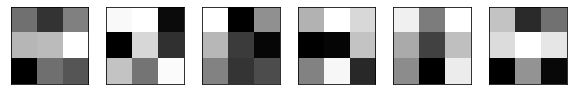

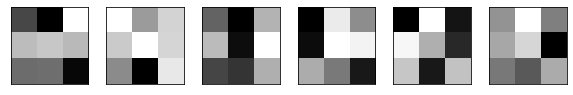

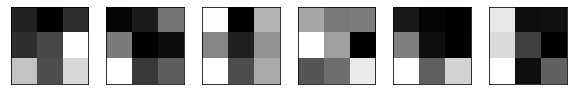

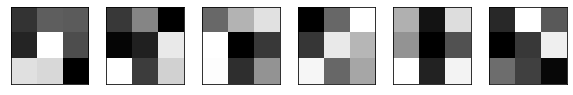

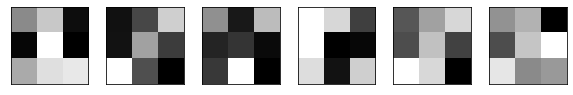

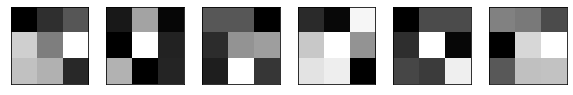

In [0]:
# minmax normalization: 마지막 conv filter
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min) 

# plot filters: 6개 씩
n_filters = 6
for i in range(n_filters):
  # get the filter
  f = filters[:, :, :, i]   # f.shape: (3,3,64)
  # plot each channel separately
  plt.figure(figsize=(10,10))
  for j in range(6):
    p_num = i*n_filters + j 
    # specify subplot and turn of axis
    ax = plt.subplot(n_filters, 6, p_num+1)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, j], cmap='gray')
# show the figure
plt.show()

### Filter map extract model define

In [0]:
# Extracts the outputs of the top 12 layers
#layer_outputs = [layer.output for layer in model_B.layers[:-1]]
ixs = [1, 4, 7]
layer_outputs = [model_BN.layers[i].output for i in ixs]
# Creates a model that will return these outputs, given the model input
# 새로운 모델 생성, 기존 모델의 parameter까지 copy, compile하면 안됨, 기존모델과 독립
fm_model = Model(inputs=model_BN.input, outputs=layer_outputs)#conv2d_6 (Conv2D)   

fm_model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 64)          0   

In [0]:
#del model_BN

### Feature maps

### Image ploting function

In [0]:
# plot n x n images
def square(imgs, n):
  img_num = n
  plt.figure(figsize=(10,10))
  for i in range(n):
    for j in range(n):
      p_num = i*n + j         
      # specify subplot and turn of axis
      ax = plt.subplot(n, n, p_num+1)   # pic position num: 1 ~ 64
      ax.set_xticks([])
      ax.set_yticks([])
      # plot filter channel in grayscale
      plt.imshow(imgs[0, :, :, p_num], cmap='gray')
  # show the figure
  plt.show()

### Get feature maps: fm_model.predict

In [0]:
# Returns a list of five Numpy arrays of layer activation
n=0
feature_maps = fm_model.predict(x_test[n:n+1,:]) 
layers_names = fm_model.output_names

### Plot the feature maps

conv2d_8


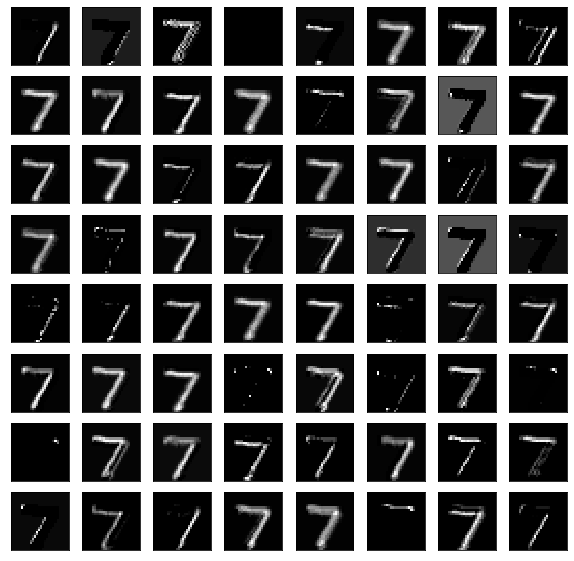

conv2d_9


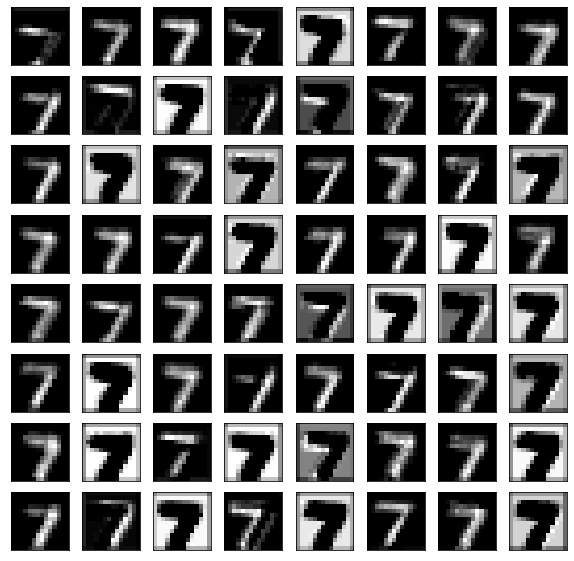

conv3rd


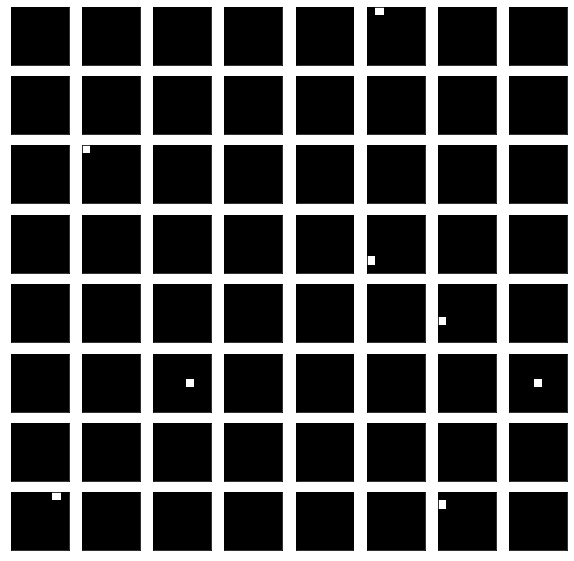

In [0]:
# plot the output from each block
for i, fmap in enumerate(feature_maps):
  print(layers_names[i])
  square(fmap, 8)

## **Analysis**

## **실습 과제**

### 과제1 feature map을 관찰해 보자 
#### -- 세번째 conv3rd layer에 l1 reguralizaion을 적용하고,
#### -- feature map이 어떻게 바뀌었는지 확인하자
#### -- 결과를 비교하고, 분석하자 :
#### ----- `activity_regularizer=keras.regularizers.l1(l=0.001)`를 써보자 


filter가 가중치, 이러한 가중치를 거쳐서 나온 것이 feature

L1은 업데이트할때마다 상수값을 계속해서 뺴준다. weight들이 동작하고 나온 feature가 까맣다는 것은 해당 위치에 연결된 노드들이 다 0이라는 것을 의미한다.

그 얘기는 반대로 하얀 색으로 칠해진 부분은 특징을 갖는 weight 들만이 관여 했다는 뜻이다. 그렇기 때문에 l2를 썼을 때는 검은 색이 더욱 많이 나오게 된다.

이러한 이론에 따르자면 L2로 하면 더 많이 보여야 하는데, 실제로 돌려봤을 때는 꼭 그런것 만은 아니다. L2는 전체적으로 노드들을 균형잡히게 성장시킨다. 문제점은 l2의 값을 잘못 설정해주면 이 과정에서 오히려 각 weight의 값이 낮아져서 까맣게 변할 수도 있다.
